# Exploratory Data Analysis

30000 patients: for each one, we have 40 features collected during his stay in the hospital ICU.
8 of them are vital signs of Sepsis, 26 are laboratory values (lab test result), and 6 are demographic/administrative values.
Before starting, we'll extract and slice the data:

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Analysis.utils import load_data, slice_data, concat_data # our own utils file, implemantation on github

In [2]:
load_data(tar_file='data.tar')
os.mkdir('Data/sliced')
# Train:
os.mkdir('Data/sliced/train')
slice_data('Data/raw/train', 'Data/sliced/train')
shutil.move('Data/sliced/train/labels.csv', 'Data/sliced/train_labels.csv')
# Test:
os.mkdir('Data/sliced/test')
slice_data('Data/raw/test', 'Data/sliced/test')
shutil.move('Data/sliced/test/labels.csv', 'Data/sliced/test_labels.csv')

Progress: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 291.82it/s]


'Data/sliced/test_labels.csv'

In [3]:
train_df = concat_data(src_dir='Data/sliced/train', dst_dir='Data/sliced', name='train')

100%|███████████████████████████████████████████████████████████████| 20000/20000 [00:41<00:00, 482.97it/s]


In [4]:
train_df.head(3)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,PatientID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,1,10022
1,58.5,96.0,NaN,133.0,54.0,30.0,28.5,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,2,10022
2,54.0,97.0,36.4,128.0,58.0,36.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,77.0,0,NaN,NaN,-679.93,3,10022


<code>train_df</code> is our full training set (20000 patients). Since the distribution of the data assumed to be real, we will analyze only the training set.

In [8]:
cols = train_df.columns
vital, lab, administrative = cols[:8], cols[8:34], cols[35:]
print("Vital:\t\t\t{}".format(list(vital)))
print("Lab test results:\t{}".format(list(lab)))
print("Administrative:\t\t{}".format(list(administrative)))

Vital:			['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
Lab test results:	['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets']
Administrative:		['Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'PatientID']


## Imbalance:
We experiment with a highly imbalanced dataset. Load train labels we save above:

In [9]:
labels = pd.read_csv('Data/sliced/train_labels.csv', index_col=0) # labels.loc[id: int] returns the label of patient_id.psv

The ratio of the first class (<code>SepsisLabel == 1</code> or positive) to the second class (<code>SepsisLabel == 0</code> or negative) instances is:

In [10]:
positive_size = len(labels.loc[labels['label'] == 1])
negative_size = len(labels.loc[labels['label'] == 0])
print('Ratio: {:.2f} : 1.'.format(negative_size/positive_size, positive_size))

Ratio: 13.13 : 1.


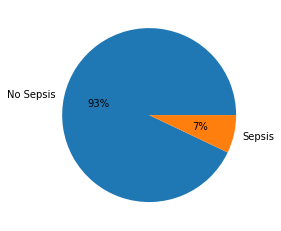

In [11]:
negative_percent = negative_size/len(labels.index)
positive_percent = positive_size/len(labels.index)
titles = ['No Sepsis', 'Sepsis']
percents = [negative_percent, positive_percent]
fig, ax = plt.subplots()
ax.pie(percents, labels=titles, autopct='%1.0f%%')
plt.show()

Based on the plot above, we may use some resampling methods later.

## Missing data:

Percentage of missing values in each column:

In [12]:
missing = train_df.isnull().sum()*100/len(train_df.index)
missing

HR                   9.952611
O2Sat               13.120266
Temp                66.091251
SBP                 14.710585
MAP                 12.551122
DBP                 31.222402
Resp                15.460834
EtCO2               96.539956
BaseExcess          94.592597
HCO3                95.882446
FiO2                91.843321
pH                  93.096075
PaCO2               94.488598
SaO2                96.547905
AST                 98.430481
BUN                 93.185898
Alkalinephos        98.447173
Calcium             94.189320
Chloride            95.525670
Creatinine          93.950984
Bilirubin_direct    99.815319
Glucose             82.850280
Lactate             97.391421
Magnesium           93.747491
Phosphate           96.056660
Potassium           90.725169
Bilirubin_total     98.551834
TroponinI           99.035925
Hct                 91.158519
Hgb                 92.644177
PTT                 97.114797
WBC                 93.637266
Fibrinogen          99.365277
Platelets 

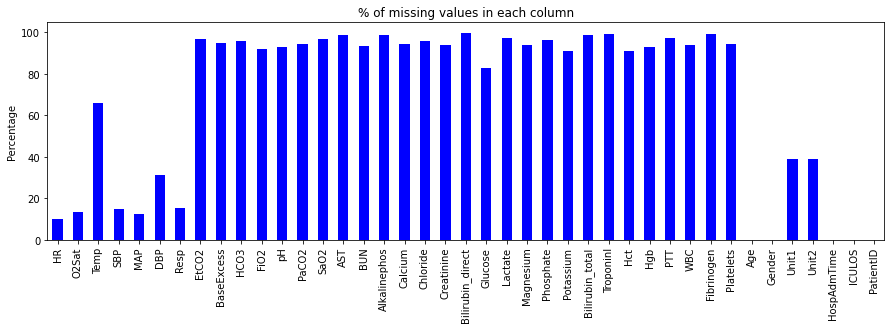

In [16]:
import matplotlib.pyplot as plt
missing.plot.bar(figsize=(15,4), color='Blue')
plt.title("% of missing values in each column")
plt.ylabel('Percentage')
plt.show()

It seems that most of the laboratory values are missing, we might use it later to decide which columns are useful and bring any value.
The vital sign EtCO2 is missing in 96.54% of the rows (yet still vital). End-Tidal CO2 is the amount of carbon dioxide (CO2) in exhaled air, which assesses ventilation. So a high ETCO2 is a good sign of good ventilation, while low ETCO2 is bad sign that represents hypoventilation.
As expected, the age and the gender (demographic) are known for all the patients (no missing data).
From this observation only, the following list may be our chosen feature set:

## Analysis:

Some important stats:

In [20]:
train_stats = train_df.describe()
train_stats.T.head() # Example:

,count,mean,std,min,25%,50%,75%,max
HR,679693.0,84.558897,17.344198,20.0,72.0,83.0,95.5,280.0
O2Sat,655783.0,97.196002,2.944657,20.0,96.0,98.0,99.5,100.0
Temp,255949.0,36.972567,0.770627,20.9,36.5,37.0,37.5,50.0
SBP,643779.0,123.550546,23.130050,20.0,107.0,121.0,138.0,299.0
MAP,660079.0,82.335320,16.282437,20.0,71.0,80.0,92.0,300.0


In [21]:
# Find IDs of positive patients ('SepsisLabel' == 1):
positive_idx = labels.loc[labels['label'] == 1].index
positive = train_df.loc[train_df['PatientID'].isin(positive_idx)]
# Find ID's of negative patients ('SepsisLabel' == 0):
negative_idx = labels.loc[labels['label'] == 0].index
negative = train_df.loc[train_df['PatientID'].isin(negative_idx)]

<code>ICU_duration.loc[k]</code> returns total hours that <code>patient_k.psv</code> was in ICU:

In [25]:
ICU_duration = train_df.PatientID.value_counts()
ICU_duration

14339    336
12953    336
17925    336
2137     331
151      327
        ... 
11242      1
8730       1
12398      1
4568       1
3553       1
Name: PatientID, Length: 20000, dtype: int64

We can observe the long right tail:


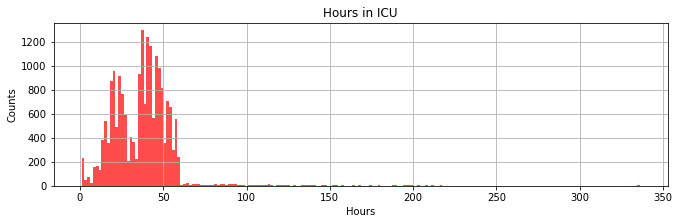

In [29]:
print("We can observe the long right tail:")
plt.figure(figsize=(11, 3))
ICU_duration.hist(bins='auto', color='Red', alpha=0.7)
plt.title('Hours in ICU')
plt.xlabel('Hours')
plt.ylabel('Counts')
plt.show()

 For example, patients who left ICU after 1 hour only and their corresponding labels. Note that all the labels appear to be positive:

In [33]:
labels.loc[ICU_duration.loc[ICU_duration == 1].index]

,label
2901,1
18393,1
5000,1
6300,1
7324,1
...,...
11242,1
8730,1
12398,1
4568,1


Approx 200 patients as seen in the histogram above. We can clearly see that there are patients who were in ICU for only one hour, mostly positive (<code>SepsisLabel == 1</code>). A possible reason for this is that they passed away, but it's just an assumption. 

The average time in ICU:

In [34]:
print(ICU_duration.mean())

37.74085


In [ ]:
df1 = train_df.copy() # df1: train_df with SepsisLabel
df1['SepsisLabel'] = df1['PatientID'].apply(lambda id: int(labels.loc[id]))

A deeper look at the distributions of the vital signs:

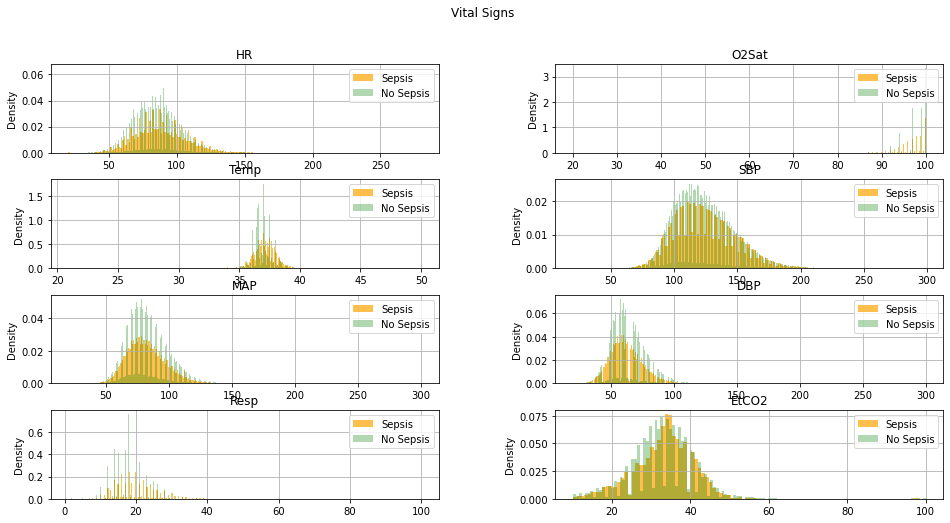

In [35]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace = .3, wspace=.3)
for i, column in enumerate(list(vital), 1):
    plt.subplot(4,2,i)
    positive[column].hist(bins='auto', color='Orange', density=1, alpha=0.7, label='Sepsis')
    negative[column].hist(bins='auto', color='Green', density=1, alpha=0.3, label='No Sepsis')
    plt.legend(loc="upper right")
    plt.title(column)
    plt.ylabel('Density')
plt.suptitle('Vital Signs')
plt.show()

<b>Feature selection:</b> We can see some minor changes in the disributuons, depend on the class. for example, <code>Resp</code>. We think we won't use <code>EtCO2</code> because it's missing as we saw before and the distributions look same. Same routine for <code>SBP</code>, the plots look the same. Based on the missing data percents we saw before and the distribution (plots) we decide which features to use. The administrative features doens't tell a lot, so we will drop them too.

## Hypothesis Testing:

We will try to compare the means of the heart <code>HR</code> rate in the classes. Based on Wikipedia, this feature value should be higher if <code>SepsisLabel == 1</code>. We use the last value measured for each patient (to simulate the closest time to start of Sepsis).

In [36]:
hr_1 = []
for patient_id, group in positive.groupby('PatientID'):
    if group['HR'].isnull().sum() == len(group.index):
        continue
    valid = group['HR'].last_valid_index()
    hr_1.append(group.iloc[valid]['HR'])

In [37]:
hr_0 = []
for patient_id, group in negative.groupby('PatientID'):
    if group['HR'].isnull().sum() == len(group.index):
        continue
    valid = group['HR'].last_valid_index()
    hr_0.append(group.iloc[valid]['HR'])

Now lets run a simple $T-test$:

In [38]:
import scipy.stats as st
print("Confidence intervals:")
print("No Speis:\t{}".format(st.t.interval(0.95, len(hr_0)-1, loc=np.mean(hr_0), scale=st.sem(hr_0))))
print("Sepsis:\t{}".format(st.t.interval(0.95, len(hr_1)-1, loc=np.mean(hr_1), scale=st.sem(hr_1))))

Confidence intervals:
No Speis:	(82.9474685276275, 83.42186738885081)
Sepsis:	(89.20450501643772, 91.30759175775582)


In [39]:
st.ttest_ind(hr_0, hr_1, equal_var=False, alternative='less')

Ttest_indResult(statistic=-12.869248117914394, pvalue=3.677158886752607e-36)

We can see how significant the results are. The $Pval$ is in fact $0$ and we can say that the mean of the negative class is smaller than the mean of the positive class (based on the last hour, a moment before the first positive label (Sepsis starts). The confidence intervals tells how big is the difference. 